# Predicting customer lifetime value using machine learning
---
### Problem Statement: Can we build an accurate model to predict next 6 month LTV at customer level?
---
### Table of Contents:

1. Load datasets, packages, and parameters
2. Customer Exploratory Analysis
3. Transactions Exploratory Analysis
4. Response Variable Creation
5. Feature Engineering
6. Model Training
    - Gradient Boosting Regression (aggregated peaks[<sup>1</sup>](#fn1) vs. non-aggregated peaks)
    - Decision Tree
    - Causal Graphical Models (aggregated peaks[<sup>1</sup>](#fn1))
    - Bayesian Networks (aggregated peaks[<sup>1</sup>](#fn1))
7. Model Evaluation
8. Inference
9. Closing Summary and Recommendations
10. Future Work
---

Footnotes: [<sup>1</sup>](#fn1)Average rolling 6 month peak by customer

---

In [1]:
%reload_kedro
from process.pipelines.data_processing import nodes as dp
from process.pipelines.data_science import nodes as ds
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd
import numpy as np
# Run help(dp) or help(ds) for documentation on functions

2021-12-08 12:18:55,294 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-12-08 12:18:55,310 - root - INFO - ** Kedro project LTV Model
2021-12-08 12:18:55,312 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-12-08 12:18:55,957 - root - WARNING - MDLP was not imported successfully


## 1. Load Raw Data Sets and Parameters

In [2]:
customers = catalog.load('customers').set_index('customer_id')
transactions = catalog.load('transactions')

2021-12-08 12:18:57,387 - kedro.io.data_catalog - INFO - Loading data from `customers` (CSVDataSet)...
2021-12-08 12:18:57,502 - kedro.io.data_catalog - INFO - Loading data from `transactions` (CSVDataSet)...


## 2. Customer Exporatory Analysis

In [3]:
customers.head()

,state,age,gender,income,is_married,promo_group_1,promo_group_2,customer_loyalty_index,brand_awareness_index
customer_id,,,,,,,,,
0,NJ,64,Female,65000.0,Y,A,X,0.058849,1.969644e-01
1,NY,26,Female,43000.0,Y,A,Z,-4.872865,2.970386e-14
2,NH,55,Female,93000.0,Y,C,X,NaN,NaN
3,ME,18,Female,68000.0,N,B,Z,0.152339,2.341961e-03
4,CA,41,Female,25000.0,N,A,Y,0.732875,8.073341e-14


Female    0.49809
Male      0.29921
Other     0.20270
Name: gender, dtype: float64


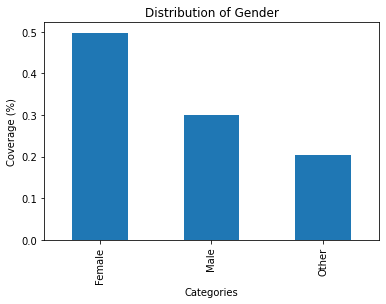

In [4]:
ax = customers.gender.value_counts(normalize = True).plot.bar()
ax.set_title("Distribution of Gender")
ax.set_xlabel("Categories")
ax.set_ylabel("Coverage (%)")
print(customers.gender.value_counts(normalize = True))

__The majority of customers are female (49%).__

N    0.56061
Y    0.43939
Name: is_married, dtype: float64


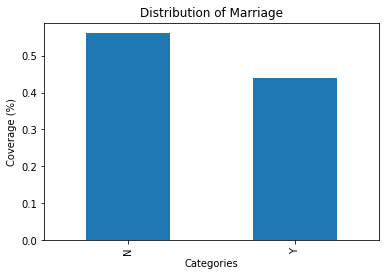

In [5]:
ax = customers.is_married.value_counts(normalize = True).plot.bar()
ax.set_title("Distribution of Marriage")
ax.set_xlabel("Categories")
ax.set_ylabel("Coverage (%)")
print(customers.is_married.value_counts(normalize = True))

__The majority of customers are not married (56%).__

In [6]:
customers[['gender','is_married']].value_counts()

gender  is_married
Female  N             28024
        Y             21785
Male    N             16627
        Y             13294
Other   N             11410
        Y              8860
dtype: int64

__The marriage rate is roughly the same between males and females, but not other.__

TX    0.113060
CA    0.112743
NJ    0.111744
NY    0.111427
GA    0.110934
NH    0.110534
FL    0.109935
ME    0.109911
MA    0.109712
Name: state, dtype: float64


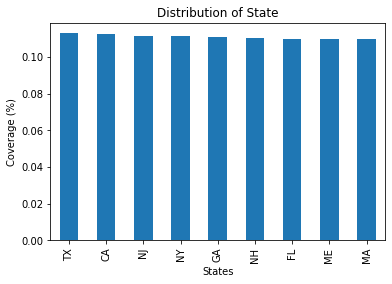

In [7]:
ax = customers.state.value_counts(normalize = True).plot.bar()
ax.set_title("Distribution of State")
ax.set_xlabel("States")
ax.set_ylabel("Coverage (%)")
print(customers.state.value_counts(normalize = True))

__We have 9 distinct states that are evenly distributed.__

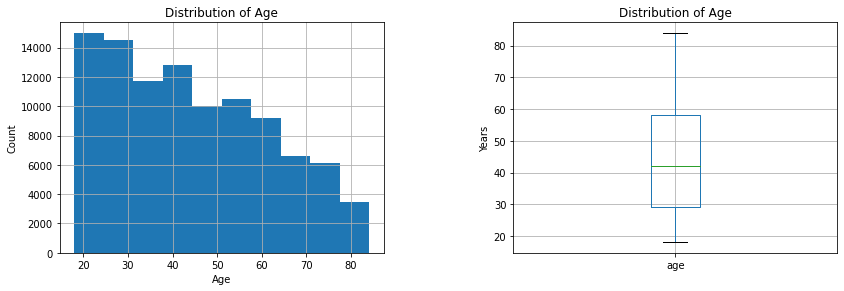

In [8]:
plt.subplot(1, 2, 1)
ax = customers.age.hist()
ax.set_title("Distribution of Age")
ax.set_xlabel("Age")
ax.set_ylabel("Count")

plt.subplot(1, 2, 2)
ax = customers.boxplot(column='age')
ax.set_title("Distribution of Age")
ax.set_ylabel("Years")                    

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

__Bottom half of customer population are between 18 and 42 (difference of 24 years), the top half are between 43 and 84 (difference 41 years)__

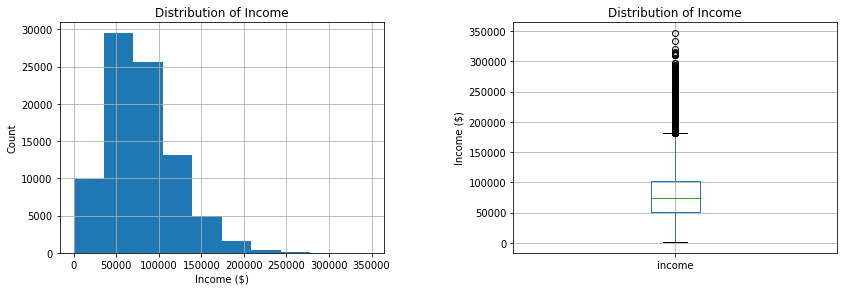

In [9]:
plt.subplot(1, 2, 1)
ax = customers.income.hist()
ax.set_title("Distribution of Income")
ax.set_xlabel("Income ($)")
ax.set_ylabel("Count")

plt.subplot(1, 2, 2)
ax = customers.boxplot(column='income')
ax.set_title("Distribution of Income")
ax.set_ylabel("Income ($)")                   

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

__Bottom half of customer population earn less than $74,000/annually__

Text(0, 0.5, 'Count')

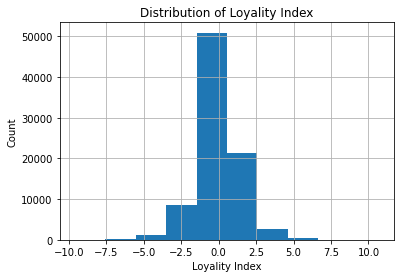

In [10]:
ax = customers.customer_loyalty_index.hist()
ax.set_title("Distribution of Loyality Index")
ax.set_xlabel("Loyality Index")
ax.set_ylabel("Count")

__Customer loyalty index appears to be normally distributed around 0.__

Text(0, 0.5, 'Count')

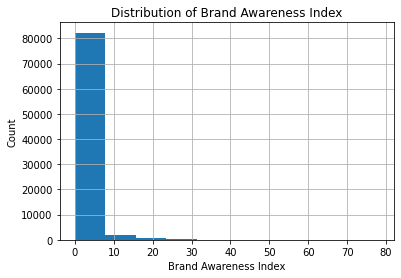

In [11]:
ax = customers.brand_awareness_index.hist()
ax.set_title("Distribution of Brand Awareness Index")
ax.set_xlabel("Brand Awareness Index")
ax.set_ylabel("Count")

__Brand Awareness has major postive skewness__

          income       age
income  1.000000  0.004502
age     0.004502  1.000000


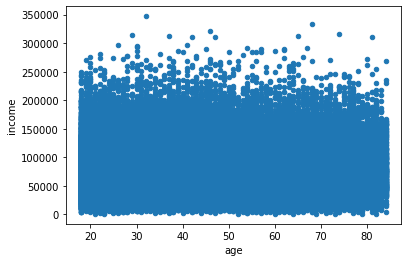

In [12]:
customers.plot.scatter(y = 'income', x = 'age')
print(customers[['income','age']].corr())

__There isn't a linear relationship between age and income__

---
__In fact, the continuous variables don't have any linear relationships.__

In [13]:
customers[['income','age','customer_loyalty_index','brand_awareness_index']].corr()

,income,age,customer_loyalty_index,brand_awareness_index
income,1.000000,0.004502,0.001694,-0.003763
age,0.004502,1.000000,0.002308,-0.000759
customer_loyalty_index,0.001694,0.002308,1.000000,-0.002624
brand_awareness_index,-0.003763,-0.000759,-0.002624,1.000000


---

#### Customer EDA Recap:
- 49% of customers are female, 29% are male, and 20% other
- 56% of customers are not married.
- Customers are only located in Texas, California, New Jersey, New York, and Georgia (evenly distributed)
- 50% of customers are under the age of 42
- 50% of customers have an annual income of $74,000
- No linear relationship between income and age
- No linear relationships between income, age, customer_loyalty, brand_awareness
- We will need to Label encode the categorical variables.
- We will need to apply Standard scale for our continuous variables.
    - We will need to apply mean imputation for nan values.
---

## 3. Transactions Exporatory Analysis

In [14]:
transactions.head()

,customer_id,transaction_value,transaction_days_after_joining
0,0,5.0,1.0
1,0,2.0,16.0
2,0,10.0,31.0
3,0,8.0,46.0
4,0,9.0,61.0


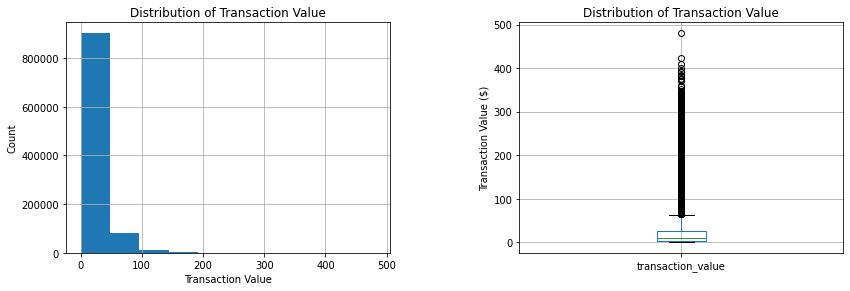

In [15]:
plt.subplot(1, 2, 1)
ax = transactions.transaction_value.hist()
ax.set_title("Distribution of Transaction Value")
ax.set_xlabel("Transaction Value")
ax.set_ylabel("Count")

plt.subplot(1, 2, 2)
ax = transactions.boxplot(column='transaction_value')
ax.set_title("Distribution of Transaction Value")
ax.set_ylabel("Transaction Value ($)")                   

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

__Bottom 50% of transaction value is between 0.00 and 11.00 dollars. Said another way, 50% of transactions are less than 11 dollars.__

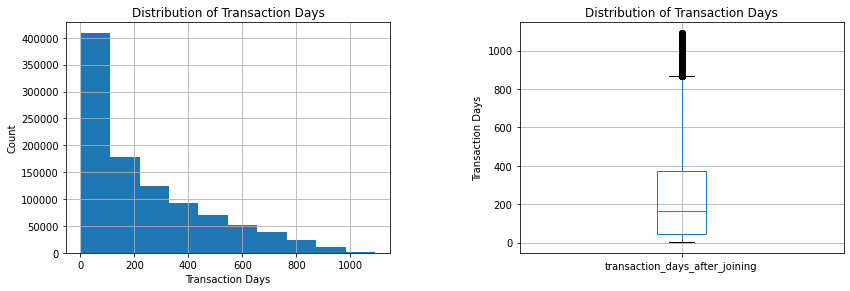

In [16]:
plt.subplot(1, 2, 1)
ax = transactions.transaction_days_after_joining.hist()
ax.set_title("Distribution of Transaction Days")
ax.set_xlabel("Transaction Days")
ax.set_ylabel("Count")

plt.subplot(1, 2, 2)
ax = transactions.boxplot(column='transaction_days_after_joining')
ax.set_title("Distribution of Transaction Days")
ax.set_ylabel("Transaction Days")                   

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

__50% of transaction are within 5 1/2 months after first transaction.__

Text(0, 0.5, 'Count')

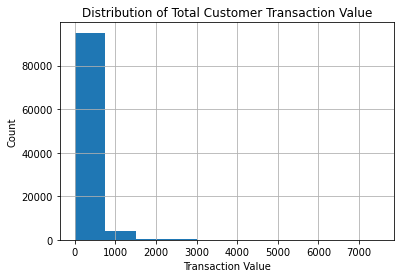

In [17]:
ax = transactions.groupby('customer_id').transaction_value.sum().hist()
ax.set_title("Distribution of Total Customer Transaction Value")
ax.set_xlabel("Transaction Value")
ax.set_ylabel("Count")                 

__50% of total customer spend is less than $89.__

---

#### Transaction EDA Recap:
- 50% of transactions occur within 5 1/2 months after first transaction
- 50% of customer total transaction value is 89 dollars.
- 50% of transactions are less than 11 dollars.
- Clear evidence of positive skewness in transaction value and transaction days.
---

## 4. Response Variable Creation

* As a reminder, our goal is to predict customer lifetime value. Customer lifetime value is next 6 month LTV.
* We define next 6 month LTV has the rolling 6 month sum of transaction value.
---
Lets go through an example. Here is the total cumulative sum of transaction value for customer_0.

<AxesSubplot:>

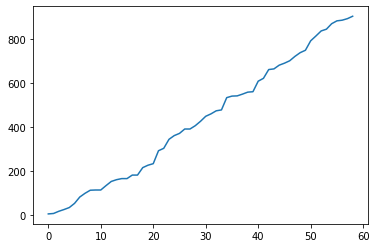

In [18]:
transactions[transactions['customer_id'] == 0]['transaction_value'].cumsum().plot()

After 866 days from the initial purchase, customer_0 has a total lifetime value of $906.

---

We can break up the cumulative sum by 180 days:

In [19]:
#Column for 180 days (6 months)
transactions['rolling_6_months'] = (
    (transactions['transaction_days_after_joining']-1) / 180).astype(int)

transactions['rolling_6_month_ltv'] = transactions.groupby(
    ['customer_id', 'rolling_6_months'])['transaction_value'].cumsum()

Text(0, 0.5, 'Transaction value ($)')

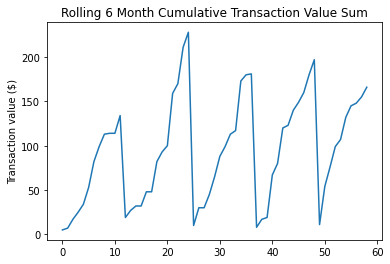

In [20]:
ax = transactions[transactions['customer_id'] == 0]['rolling_6_month_ltv'].plot()
ax.set_title("Rolling 6 Month Cumulative Transaction Value Sum")
ax.set_ylabel("Transaction value ($)")

The peaks tell us the total transaction value within a rolling 180 day period. We will use the peaks as the response variables, because our goal is to predict the next 6 month ltv. Therefore we want to learn from the historical 6 month total ltv for each customer. 

---

Our response variable is the rolling 180 day cumulative transaction value for each customer (rolling_6_month_ltv)

In [21]:
rolling_ltv = dp.target_variable(transactions)
rolling_ltv.head()

,rolling_6_months,rolling_6_month_ltv
customer_id,,
0,0,134.0
0,1,228.0
0,2,181.0
0,3,197.0
0,4,166.0


In [22]:
#Build our repsonse variable for the feature table
response = dp.target_variable(transactions).drop('rolling_6_months', axis = 1)

---

## 5. Feature Engineering

We will use a feature engineering map to provide standard scaler and label encoding on the customers table. The map is shown below which is loaded via the parameters.yml file.

In [23]:
parameters = catalog.load('parameters')
parameters['feature_engineering_map']

2021-12-08 12:19:22,635 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


{'state': 'label',
 'gender': 'label',
 'is_married': 'label',
 'promo_group_1': 'label',
 'promo_group_2': 'label',
 'age': 'continuous',
 'income': 'continuous',
 'customer_loyalty_index': 'continuous',
 'brand_awareness_index': 'continuous'}

In [24]:
cont_features = dp.continuous_variables(customers, parameters)
help(dp.continuous_variables)
cat_features, label_mapping = dp.categorical_variables(customers, parameters)
help(dp.categorical_variables)

Help on function continuous_variables in module process.pipelines.data_processing.nodes:

continuous_variables(df: pandas.core.frame.DataFrame, parameters: Dict) -> pandas.core.frame.DataFrame
    Scale continuous variables using scikit learn Standard Scaler with mean imputation
    
    Args:
        df (pd.DataFrame): raw feature table
        parameters ([type], optional): dictionary of feature and type mapping.
    
    Returns:
        Tuple: scaled dense feature table and scalar mapping

Help on function categorical_variables in module process.pipelines.data_processing.nodes:

categorical_variables(df: pandas.core.frame.DataFrame, parameters: Dict) -> Tuple
    Convert categorical variables to continuous variables using scikit learn label encoder. Also provide label encode mapping as seperate mapping.
    
    Args:
        df (pd.DataFrame): dense raw features
        parameters ([type], optional): dictionary of feature and type mapping. Defaults to None.
    
    Returns:
     

In [25]:
# Standard scaling on continusous features
cont_features.head()

,age,income,customer_loyalty_index,brand_awareness_index
0,1.123826,-0.369170,0.039494,-0.253363
1,-1.045294,-0.919187,-3.448415,-0.316156
2,0.610087,0.330852,0.000000,0.000000
3,-1.501951,-0.294167,0.105614,-0.315410
4,-0.189062,-1.369201,0.516192,-0.316156


In [26]:
#Label encoding for categorical features
cat_features.head()

,state_label,gender_label,is_married_label,promo_group_1_label,promo_group_2_label
customer_id,,,,,
0,6,0,1,0,0
1,7,0,1,0,2
2,5,0,1,2,0
3,4,0,0,1,2
4,0,0,0,0,1


In [27]:
#label encoded mapping
label_mapping.head()

,input,output,attribute
0,CA,0,state
1,FL,1,state
2,GA,2,state
3,MA,3,state
4,ME,4,state


One last step in our feature table process is dropping variables with high multicollinearity (as measured with VIF).

To view logic for VIF please see below or visit /src/process/pipelines/data_processing/nodes.py

In [28]:
help(dp.target_variable)
print("--------------------------------------------------------------------------------")
help(dp._calculate_vif)
print("--------------------------------------------------------------------------------")
help(dp.standardized_feature_table)
print("--------------------------------------------------------------------------------")
response = dp.target_variable(transactions)
feature_table = dp.standardized_feature_table(response, cont_features, cat_features)

Help on function target_variable in module process.pipelines.data_processing.nodes:

target_variable(transactions: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame
    Calculate the rolling 6 month LTV
    
    Args:
        transactions (pd.DataFrame): customer transactions
    
    Returns:
        pd.DataFrame: customer transactions with rolling 6 month LTV

--------------------------------------------------------------------------------
Help on function _calculate_vif in module process.pipelines.data_processing.nodes:

_calculate_vif(feature_table: pandas.core.frame.DataFrame, thresh=5.0) -> pandas.core.frame.DataFrame
    Remove multicollinearity in feature table using vif with a threshold of 5.0 (leverages parallel runs).
    
    Args:
        feature_table (pd.DataFrame): standardized feature table
        thresh (float, optional): vif threshold. Defaults to 5.0.
    
    Returns:
        pd.DataFrame: standardized feature table with low multicollinearity

----------

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    1.4s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.5s finished


Remaining variables:
[['state_label', 'gender_label', 'is_married_label', 'promo_group_1_label', 'promo_group_2_label', 'age', 'income', 'customer_loyalty_index', 'brand_awareness_index']]


__We didn't lose any features to VIF. This means features are not highly correlated with each other.__

In [29]:
#Non-aggregated peaks. Note: customers are the index.
feature_table.head()

,rolling_6_months,rolling_6_month_ltv,state_label,gender_label,is_married_label,promo_group_1_label,promo_group_2_label,age,income,customer_loyalty_index,brand_awareness_index
0,0,134.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,1,228.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,2,181.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,3,197.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,4,166.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363


## 6. Model Training

### Gradient Boosting Regression

In [181]:
help(ds._split_data)
X_train, X_test, y_train, y_test = ds._split_data(feature_table, "rolling_6_month_ltv", 0.2)

Help on function _split_data in module process.pipelines.data_science.nodes:

_split_data(feature_table: pandas.core.frame.DataFrame, response: str, test_size: float) -> Tuple
    Split data into train and test set using scikit learn package.
    
    Args:
        feature_table (pd.DataFrame): standardized feature table
        response (str): 6 month rolling ltv
        test_size (float): Percentage of test size
    
    Returns:
        Tuple: X_train, X_test, y_train, y_test



Our first model is gradient boosting regression. I choose to use this model for the following reasons:
* Ability to optimize on a determined loss function
* Tree-based model (doesn't assume linear structures in data)
* Industry standard for accuracy and speed

Help on function gradientBoostingRegressor in module process.pipelines.data_science.nodes:

gradientBoostingRegressor(X_train: pandas.core.frame.DataFrame, X_test: pandas.core.frame.DataFrame, y_train: pandas.core.frame.DataFrame, y_test: pandas.core.frame.DataFrame, n_feat: int) -> Any
    Gradient boosting regression model with recursive feature elimination.
    
    Model Parameters:
        n_estimators: 500
        max_depth: 4
        min_samples_split: 5
        learning_rate: 0.01
    
    Args:
        X_train (pd.DataFrame): Feature training set
        X_test (pd.DataFrame): Feature test set
        y_train (pd.DataFrame): Response training set
        y_test (pd.DataFrame): Response testing set
        n_feat (int): Top N features to select
    
    Returns:
        GradientBoostingRegressor: scikit learn object
        Dict: Model Evaluation Metrics

MSE: 9783.0927
Explained variance: 0.387


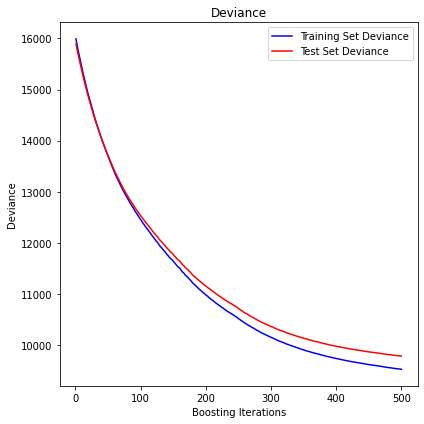

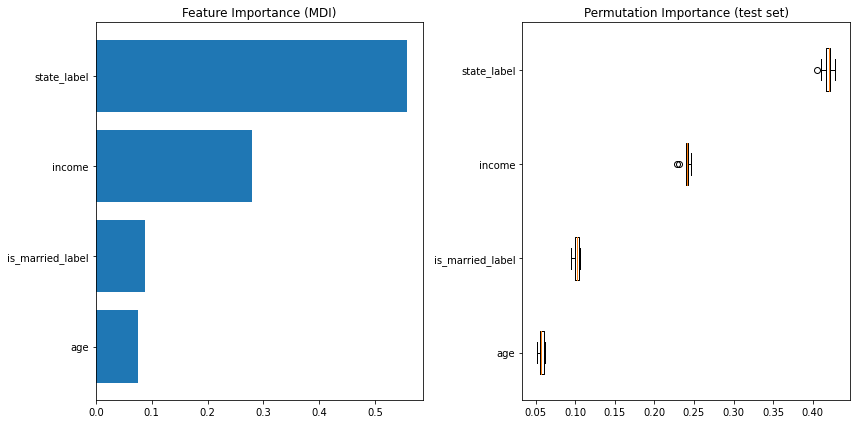

In [182]:
help(ds.gradientBoostingRegressor)
gradBoostReg, metrics = ds.gradientBoostingRegressor(X_train, X_test, y_train, y_test, 5)

In [183]:
metrics

{'model': 'Gradient Boost',
 'metrics': {'mse': 9783.092693715658,
  'explained variance': 0.3872015996374738}}

---

Our original feature table contains multiple peaks for customers, this will result in duplicate features. For example here is customer_0:

In [184]:
feature_table[feature_table.index==0]

,rolling_6_months,rolling_6_month_ltv,state_label,gender_label,is_married_label,promo_group_1_label,promo_group_2_label,age,income,customer_loyalty_index,brand_awareness_index
0,0,134.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,1,228.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,2,181.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,3,197.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,4,166.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363


---

I want to aggregate the peaks to an average and test how that changes MSE and Explained Variance.

In [185]:
aggregated_peaks = feature_table.groupby(level=0).mean().drop('rolling_6_months', axis = 1)

MSE: 7758.4914
Explained variance: 0.457


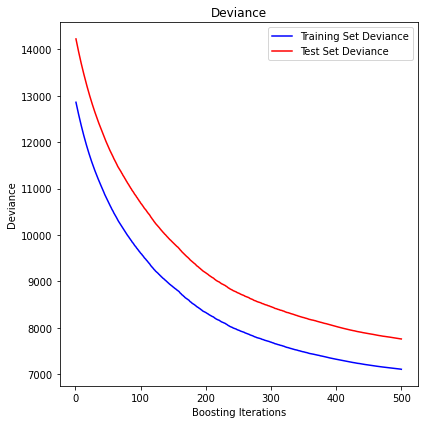

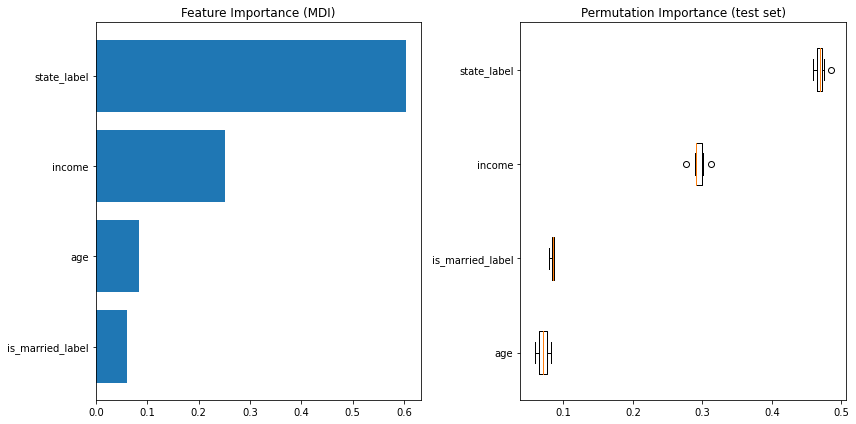

In [186]:
X_train, X_test, y_train, y_test = ds._split_data(aggregated_peaks, "rolling_6_month_ltv", 0.2)
gradBoostRegPeaks, metrics = ds.gradientBoostingRegressor(X_train, X_test, y_train, y_test, 5)

In [187]:
metrics

{'model': 'Gradient Boost',
 'metrics': {'mse': 7758.491354070322,
  'explained variance': 0.45734478639100673}}

The MSE decrease and Explained Variance increases. State and income are much more important to the model post peak aggregation. We did reduce the dataset, therefore might be overfitting.

### Decision Tree

In [40]:
X_train, X_test, y_train, y_test = ds._split_data(feature_table, "rolling_6_month_ltv", 0.2)

Help on function DecisionTree in module process.pipelines.data_science.nodes:

DecisionTree(X_train: pandas.core.frame.DataFrame, X_test: pandas.core.frame.DataFrame, y_train: pandas.core.frame.DataFrame, y_test: pandas.core.frame.DataFrame) -> Any
    Scikit Learn Decision Tree Regression Model.
    
    Args:
        X_train (pd.DataFrame): Feature training set
        X_test (pd.DataFrame): Feature test set
        y_train (pd.DataFrame): Response training set
        y_test (pd.DataFrame): Response testing set
    
    Returns:
        DecisionTreeRegressor: scikit learn object
        Dict: Model Evaluation Metrics

Base model with all features ...
MSE: 13955.8695
Explained variance: 0.126


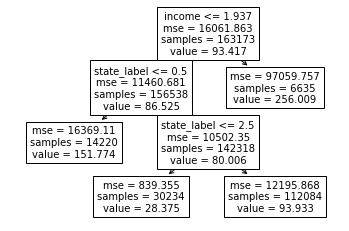

In [41]:
from process.pipelines.data_science import nodes as ds
help(ds.DecisionTree)
decisionTree, metrics = ds.DecisionTree(X_train, X_test, y_train, y_test)

Decision Tree is less accurate and can't explain the variance very well. The main features in making decision were income and state.

---

---

### Causal Graphical Models

This analysis will use structural Causal models to determine features that have Causal affects on rolling 6 month lifetime value. 
The Causal model is built using [DAGs with NO Tears](https://proceedings.neurips.cc/paper/2018/file/e347c51419ffb23ca3fd5050202f9c3d-Paper.pdf) from a pandas dataframe.

In [125]:
from causalnex.structure.notears import from_pandas
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

In [126]:
aggregated_peaks.head()

,rolling_6_month_ltv,state_label,gender_label,is_married_label,promo_group_1_label,promo_group_2_label,age,income,customer_loyalty_index,brand_awareness_index
0,181.200000,6.0,0.0,1.0,0.0,0.0,1.123826,-0.369170,0.039494,-0.253363
1,389.400000,7.0,0.0,1.0,0.0,2.0,-1.045294,-0.919187,-3.448415,-0.316156
2,73.000000,5.0,0.0,1.0,2.0,0.0,0.610087,0.330852,0.000000,0.000000
3,60.000000,4.0,0.0,0.0,1.0,2.0,-1.501951,-0.294167,0.105614,-0.315410
4,76.666667,0.0,0.0,0.0,0.0,1.0,-0.189062,-1.369201,0.516192,-0.316156


In [127]:
sm = from_pandas(aggregated_peaks)

2021-12-06 19:20:34,430 - root - INFO - Learning structure using 'NOTEARS' optimisation.


/home/ubuntu/ltv_model/venv/lib/python3.8/site-packages/networkx/convert_matrix.py:680: DeprecationWarning: from_numpy_matrix is deprecated and will be removed in NetworkX 3.0.
Use from_numpy_array instead, e.g. from_numpy_array(A, **kwargs)
  warnings.warn(


/home/ubuntu/ltv_model/venv/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'rolling_6_month_ltv', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


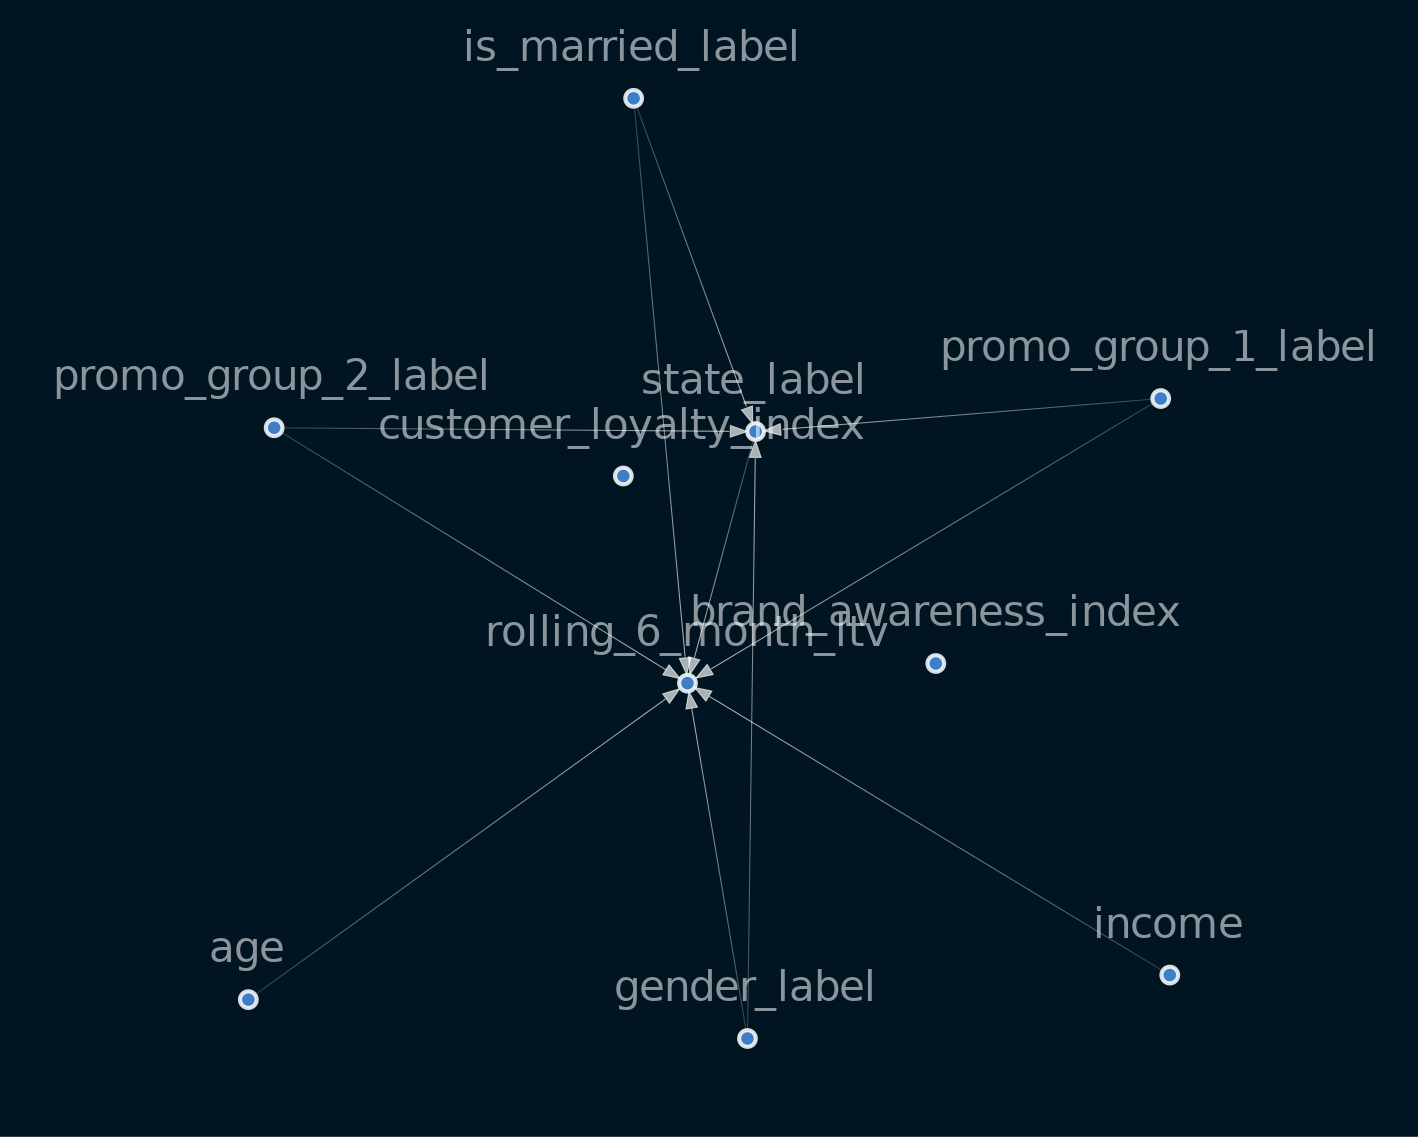

In [128]:
#Remove weak edges
sm.remove_edges_below_threshold(0.9)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "1.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

__Key Takeaways:__
- Age, Gender, Income, Promo Group (1 and 2), State, and Marriage Status all have Causal affects on Rolling 6 Month LTV.
- Brand Awareness and Customer Loyalty do not affect Rolling 6 Month LTV.
- Gender, Promo Group (1 and 2), and Marriage Status also have Causal affects on State.

In [129]:
#We can remove unused nodes.
sm.remove_node('customer_loyalty_index')
sm.remove_node('brand_awareness_index')

---

### Bayesian Networks

To make predictions from our Causal network we need to transform it into a discrete Conditional Probability Distribution between variables (i.e. Bayesian Network).

In [130]:
from causalnex.network import BayesianNetwork
bn = BayesianNetwork(sm)

/home/ubuntu/ltv_model/venv/lib/python3.8/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


It's important to discretize our dataframe otherwise we will have a combinatorial explosion

In [298]:
discretised_data = dp.discretiser(aggregated_peaks)

In [149]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

Next we will fit our discrete data into a conditional probability density albeit discrete distributions.

In [150]:
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

We can make predictions on our main data set.

In [161]:
predictions = bn.predict(discretised_data, "rolling_6_month_ltv")
predictions.head()

,rolling_6_month_ltv_prediction
0,8
1,8
2,4
3,5
4,5


We need to convert our bins back into the nominal LTV values.

In [212]:
pred_map = dict(zip(predictions['rolling_6_month_ltv_prediction'].sort_values().unique(), [aggregated_peaks['rolling_6_month_ltv'].quantile(i) for i in np.arange(.1, 1., .1)]))
predictions['bayes_ltv_prediction'] = predictions['rolling_6_month_ltv_prediction'].replace(pred_map)
predictions.head()

,rolling_6_month_ltv_prediction,nominal_ltv_prediction,bayes_ltv_prediction
0,8,212.000,212.000
1,8,212.000,212.000
2,4,50.775,50.775
3,5,70.000,70.000
4,5,70.000,70.000


In [174]:
from causalnex.evaluation import classification_report
classification_evaluation = pd.DataFrame(classification_report(bn, test, "rolling_6_month_ltv"))

In [177]:
classification_evaluation

,rolling_6_month_ltv_0,rolling_6_month_ltv_1,rolling_6_month_ltv_2,rolling_6_month_ltv_3,rolling_6_month_ltv_4,rolling_6_month_ltv_5,rolling_6_month_ltv_6,rolling_6_month_ltv_7,rolling_6_month_ltv_8,rolling_6_month_ltv_9,accuracy,macro avg,weighted avg
precision,0.137794,0.159780,0.127234,0.105660,0.126304,0.124043,0.145092,0.164456,0.283267,0.338323,0.1617,0.171195,0.171040
recall,0.397289,0.174174,0.122718,0.085453,0.102060,0.084463,0.098646,0.121927,0.208535,0.234440,0.1617,0.162971,0.161700
f1-score,0.204619,0.166667,0.124935,0.094488,0.112895,0.100496,0.117444,0.140034,0.240223,0.276961,0.1617,0.157876,0.157426
support,959.000000,999.000000,986.000000,983.000000,1068.000000,959.000000,1034.000000,1017.000000,1031.000000,964.000000,0.1617,10000.000000,10000.000000


We can also view marginal probabilities for each factors in our conditional probability distribution. In this case all of our bins have an equal 

In [155]:
from causalnex.inference import InferenceEngine
ie = InferenceEngine(bn)
marginals = ie.query()
marginals["rolling_6_month_ltv"]

{0: 0.1012374693799195,
 1: 0.10190021800878164,
 2: 0.10157976645403961,
 3: 0.10000114418918167,
 4: 0.10105624133352802,
 5: 0.09948997913515162,
 6: 0.09922850362029356,
 7: 0.09900999891735206,
 8: 0.09857231555619365,
 9: 0.09792436340554879}

## 7. Model Evaluation

We trained 3 distinct models:
- Gradient boosting regression
    - Gradient boosting preformed the best when compared against Decision tree (based on MSE and explained variance). 
    - The most important features to the model were State, Income, Age, and Marriage.
    - The algorithm hits an optimal number of estimators around 200-300 iterations.
- Decision tree
    - The decision tree preformed worse compared to gradient boosting. 
    - The main features in the decision making process were Income then State.
- Bayesian network (built from Causal graph)
    - Age, Gender, Income, Promo Group (1 and 2), State, and Marriage Status all have Causal affects on Rolling 6 Month LTV.
    - Brand Awareness and Customer Loyalty do not affect Rolling 6 Month LTV.
    - Gender, Promo Group (1 and 2), and Marriage Status also have Causal affects on State.
    - Classifcation report shows poor accuracy levels (16%)
    - Marginal probabilities show an uniform distribution of likelihood for the classes

State was a common theme of predictive power. The rolling 6 month ltv by state has a stark distribution:

In [40]:
state_value = pd.merge(customers, response.groupby(level=0).rolling_6_month_ltv.mean(), on = 'customer_id')
state_value.head()

,state,age,gender,income,is_married,promo_group_1,promo_group_2,customer_loyalty_index,brand_awareness_index,state_label,gender_label,is_married_label,promo_group_1_label,promo_group_2_label,rolling_6_month_ltv
customer_id,,,,,,,,,,,,,,,
0,NJ,64,Female,65000.0,Y,A,X,0.058849,1.969644e-01,6,0,1,0,0,181.200000
1,NY,26,Female,43000.0,Y,A,Z,-4.872865,2.970386e-14,7,0,1,0,2,389.400000
2,NH,55,Female,93000.0,Y,C,X,NaN,NaN,5,0,1,2,0,73.000000
3,ME,18,Female,68000.0,N,B,Z,0.152339,2.341961e-03,4,0,0,1,2,60.000000
4,CA,41,Female,25000.0,N,A,Y,0.732875,8.073341e-14,0,0,0,0,1,76.666667


In [41]:
state_value.groupby('state').rolling_6_month_ltv.mean().sort_values()

state
FL       27.838376
GA       29.359741
TX       35.423522
NH       45.149158
ME       62.558968
None     89.455342
NJ       91.063734
CA      165.829602
NY      175.520381
MA      176.848670
Name: rolling_6_month_ltv, dtype: float64

## 8. Inference

Our goal for inference is to provide a 6 month LTV value prediction. We have 4 model outputs (gradBoostReg_pred, decisionTree_pred, gradBoostRegPeaks_pred, bayes_ltv_prediction).

The decision tree has a very uninformative predictions distribution and I decided to exclude it from our predictions dataframe. Finally I aggregated gradBoostReg_pred, gradBoostRegPeaks_pred, and bayes_ltv_prediction on a weighted average. The reason being the bayesian network preformed poorly on the classification report.

In [254]:
last_purchase = transactions.groupby('customer_id')['transaction_value'].last()
feature_table['gradBoostReg_pred'] = gradBoostReg.predict(feature_table[["state_label", "income", "is_married_label", "age"]])
feature_table['decisionTree_pred'] = decisionTree.predict(feature_table[[i for i in list(feature_table) if 'rolling_6_month_ltv' not in i and 'pred' not in i]])
non_agg_peak_preds = feature_table.groupby(level=0)[['gradBoostReg_pred','decisionTree_pred']].mean()
aggregated_peaks['gradBoostRegPeaks_pred'] = gradBoostRegPeaks.predict(aggregated_peaks[["state_label", "income", "is_married_label", "age"]])

inference = pd.concat([non_agg_peak_preds, aggregated_peaks['gradBoostRegPeaks_pred'], predictions['bayes_ltv_prediction']], axis = 1)

In [286]:
inference.head()

,gradBoostReg_pred,gradBoostRegPeaks_pred,bayes_ltv_prediction,Expected LTV (Next 6 Months),Historical Avg 6 Months LTV,postive_prediction
0,61.676874,57.235831,212.000,74.488665,181.200000,1
1,103.929053,107.355042,212.000,116.449142,389.400000,1
2,26.752507,26.659343,50.775,29.108174,73.000000,1
3,29.163108,27.375852,70.000,32.353169,60.000000,1
4,102.470778,100.311768,70.000,98.144195,76.666667,0


<AxesSubplot:ylabel='Density'>

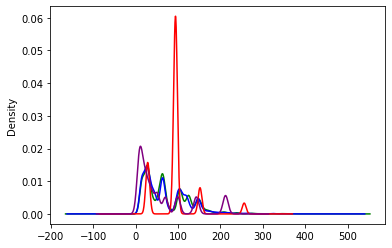

In [250]:
inference.gradBoostReg_pred.plot.density(color='green') 
inference.gradBoostRegPeaks_pred.plot.density(color='blue')
inference.decisionTree_pred.plot.density(color='red')
inference.bayes_ltv_prediction.plot.density(color='purple')

By removing decision tree we remove the large predictions around 100.

<AxesSubplot:ylabel='Density'>

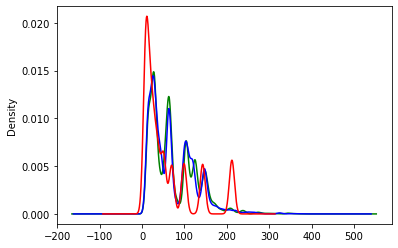

In [252]:
inference.gradBoostReg_pred.plot.density(color='green') 
inference.gradBoostRegPeaks_pred.plot.density(color='blue')
inference.bayes_ltv_prediction.plot.density(color='red')

Our weighted average is a subjective weighting scheme based on model performance.

In [278]:
inference['Expected LTV (Next 6 Months)'] = (inference['gradBoostReg_pred'] * 0.4) + (inference['gradBoostRegPeaks_pred'] * 0.5) + (inference['bayes_ltv_prediction'] * 0.1)

<AxesSubplot:ylabel='Density'>

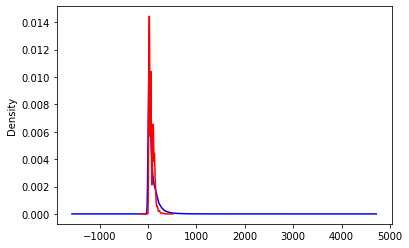

In [279]:
inference['Historical Avg 6 Months LTV'] = aggregated_peaks['rolling_6_month_ltv']
inference['Historical Avg 6 Months LTV'].plot.density(color='blue')
inference['Expected LTV (Next 6 Months)'].plot.density(color='red')

Finally, we can see that our prediction yield interesting results. 50% of customers are expected to have an increase in LTV and 50% are expected to decrease spend compared to there historical 6 month spend.

In [287]:
inference['postive_prediction'] = np.where(inference['Historical Avg 6 Months LTV'] - inference['Expected LTV (Next 6 Months)'] > 0, 1, 0)
inference['postive_prediction'].value_counts(normalize = True)

0    0.50872
1    0.49128
Name: postive_prediction, dtype: float64

In [290]:
#Difference between average spend
inference['Historical Avg 6 Months LTV'].mean() - inference['Expected LTV (Next 6 Months)'].mean()

18.898982107317977

In [284]:
inference.head()

,gradBoostReg_pred,gradBoostRegPeaks_pred,bayes_ltv_prediction,Expected LTV (Next 6 Months),Historical Avg 6 Months LTV,postive_prediction
0,61.676874,57.235831,212.000,74.488665,181.200000,1
1,103.929053,107.355042,212.000,116.449142,389.400000,1
2,26.752507,26.659343,50.775,29.108174,73.000000,1
3,29.163108,27.375852,70.000,32.353169,60.000000,1
4,102.470778,100.311768,70.000,98.144195,76.666667,0


## 9. Closing Summary and Recommendations

* The purpose of this analysis was to use machine learning to predict the LTV for the next 6 months at the customer level. 
* We aggregated the rolling 6 month LTV as a response variable. This lead to duplicates in our feature table as some of the customers had multiple 180 day periods.
* We found out that averaging the rolling 6 month LTV proved higher accuracy in the gradient boosting regression model.
* The gradient regression models both used State, Income, Age, and Gender as the most important features when training.
* The decision tree classifier did not prove to be useful due to poor accuracy and uninformative inference distribution.
* The Causal network gave insight into Causal affects in our observational data. Age, Gender, Income, Promo Group (1 and 2), State, and Marriage Status all have Causal affects on Rolling 6 Month LTV. However, the classifcation report shows poor accuracy levels.
* We used an ensemble model for predictions, were we took a weighted average between two gradient boosting models and the bayesian network.
* Our Expected LTV on average is $18.89 lower compared to our historical 6 month LTV. That is largely due to the high outliers in the historical figures

## 10. Future Work

This work can be approved on by doing the following:
* Removing extreme outliers from the analysis
* State of the art time series modeling (HMM and Deep Learning)
* Random forest regressor